In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms

# ==== Thiết lập ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_MSG_LEN = 256  # tối đa 32 ký tự

# ==== Hàm chuyển đổi văn bản <-> tensor ảnh ====
def text_to_binary(text):
    bits = ''.join([format(byte, '08b') for byte in text.encode('utf-8')])  # Dùng UTF-8 thay vì ASCII
    bits = bits.ljust(MAX_MSG_LEN * 8, '0')  # pad cho đủ độ dài cố định
    return bits

def binary_to_text(bits):
    byte_array = bytearray([int(bits[i:i+8], 2) for i in range(0, len(bits), 8)])
    return byte_array.decode('utf-8', errors="ignore")  # Dùng UTF-8

def text_to_tensor(text, H, W):
    bits = text_to_binary(text)
    arr = np.array([int(b) for b in bits], dtype=np.float32)
    arr = np.resize(arr, (H, W))  # reshape thành ảnh
    return torch.tensor(arr).unsqueeze(0)  # (1, H, W)

def tensor_to_text(tensor):
    bits = tensor.detach().cpu().numpy().flatten()
    bits = ['1' if b > 0.5 else '0' for b in bits[:MAX_MSG_LEN * 8]]
    return binary_to_text(''.join(bits))

# ==== Mô hình Encoder ====
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=1)
        )

    def forward(self, image, message):
        combined = torch.cat([image, message], dim=1)
        encoded_image = self.encoder(combined)
        return encoded_image

# ==== Mô hình Decoder ====
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, encoded_image):
        return self.decoder(encoded_image)
    
# ==== Dataset ====


class CocoStuffDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        try:
            img = Image.open(img_path).convert("RGB")  # Đảm bảo ảnh không bị lỗi
        except Exception as e:
            print(f"❌ Lỗi khi tải ảnh: {img_path} | {e}")
            return None, None  # Tránh lỗi batch

        if self.transform:
            img = self.transform(img)
        return img, 0  # Trả về ảnh + nhãn giả (để giữ cú pháp CIFAR)

# Định nghĩa dataset CocoStuff
img_dir = r"D:/HHT/UIT/AZCode/Python/Data Hiding/0.Dataset/Cocostuff/cover_images"
transform = transforms.Compose([
    transforms.Resize((256,256)),  # Resize về kích thước 32x32 như CIFAR
    transforms.ToTensor(),        # Chuyển ảnh sang tensor (C, H, W) ∈ [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh
])

trainset = CocoStuffDataset(img_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

# Kiểm tra batch đầu tiên
for images, _ in trainloader:
    print(f"✅ Batch hợp lệ, shape: {images.shape}")
    break

encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
criterion = nn.BCELoss()



# ==== Huấn luyện ====
alpha = 0.7  # ưu tiên độ trung thực ảnh

for epoch in range(3):
    for images, _ in trainloader:
        images = images.to(device)
        B, C, H, W = images.shape

        texts = ["Xin chào @ Stegano! Hồ Hải Triều 16/05/1981. Chúc Bạn thành công"] * B
        messages = torch.stack([text_to_tensor(txt, H, W) for txt in texts]).to(device)

        optimizer.zero_grad()
        encoded_images = encoder(images, messages)
        decoded_messages = decoder(encoded_images)

        loss_msg = criterion(decoded_messages, messages)
        loss_img = F.mse_loss(encoded_images, images)
        loss = loss_msg + alpha * loss_img

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss msg: {loss_msg.item():.4f} | Loss img: {loss_img.item():.4f}")

 



✅ Batch hợp lệ, shape: torch.Size([16, 3, 256, 256])
Epoch 1 | Loss msg: 0.0052 | Loss img: 0.0277
Epoch 2 | Loss msg: 0.0024 | Loss img: 0.0140
Epoch 3 | Loss msg: 0.0015 | Loss img: 0.0128


import torch
# Đường dẫn lưu mô hình
torch.save(encoder.state_dict(), "encoder_model.pth")
torch.save(decoder.state_dict(), "decoder_model.pth")
print("✅ Đã lưu toàn bộ mô hình sau train!")

In [4]:
print(f"✅ Số lượng ảnh tìm thấy: {len(os.listdir(img_dir))}")
print(f"✅ Danh sách ảnh: {os.listdir(img_dir)[:5]}")  # Hiển thị 5 ảnh đầu tiên
import torch
# Đường dẫn lưu mô hình
torch.save(encoder.state_dict(), "encoder_model.pth")
torch.save(decoder.state_dict(), "decoder_model.pth")
print("✅ Đã lưu toàn bộ mô hình sau train!")

✅ Số lượng ảnh tìm thấy: 9583
✅ Danh sách ảnh: ['COCO_train2014_000000000077.png', 'COCO_train2014_000000000113.png', 'COCO_train2014_000000000127.png', 'COCO_train2014_000000000260.png', 'COCO_train2014_000000000349.png']
✅ Đã lưu toàn bộ mô hình sau train!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


>>> Gốc: Hồ Hải Triều 16/05/1981.Hello Stegano! This is a secret message!
>>> Trích xuất: Hồ Hải Triều 16/05/1981.Hello Stegano! This is a secret message!                                                                                                                                                                                          


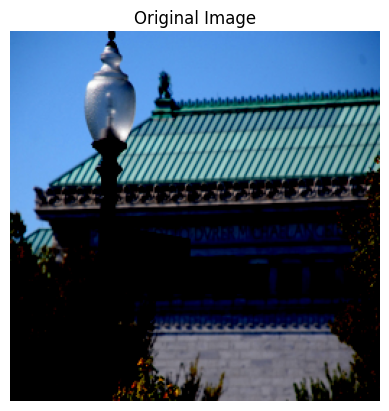

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1778331..1.2391484].


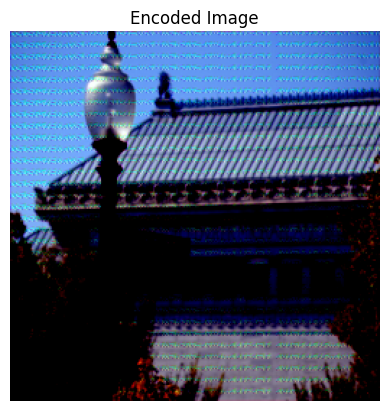

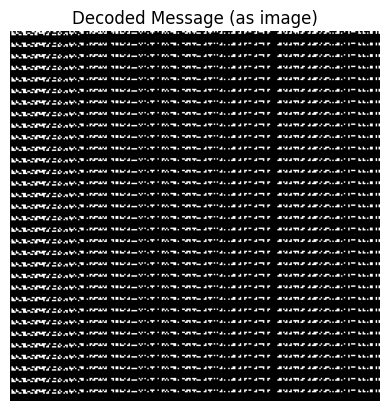

✅ Đã lưu ảnh! Kiểm tra 'original_image.png' và 'decoded_message.png' để so sánh.


In [8]:
# ==== Demo trích xuất văn bản thực ====
test_text = "Hồ Hải Triều 16/05/1981.Hello Stegano! This is a secret message!"
test_img, _ = next(iter(trainloader))
test_img = test_img[0:1].to(device)
test_msg_tensor = text_to_tensor(test_text, H, W).unsqueeze(0).to(device)

with torch.no_grad():
    encoded = encoder(test_img, test_msg_tensor)
    decoded = decoder(encoded)

# ==== Hiển thị ====
def show_tensor_img(tensor, title=""):
    npimg = tensor.squeeze().detach().cpu().numpy()
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))
    else:
        npimg = npimg
    plt.imshow(npimg, cmap='gray' if npimg.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

recovered_text = tensor_to_text(decoded[0])
print(">>> Gốc:", test_text)
print(">>> Trích xuất:", recovered_text)

show_tensor_img(test_img[0], "Original Image")
show_tensor_img(encoded[0], "Encoded Image")
show_tensor_img(decoded[0], "Decoded Message (as image)")

import torchvision.utils as vutils

# Lưu ảnh gốc
vutils.save_image(test_img[0], "original_image.png")

# Lưu ảnh đã mã hóa (có chứa dữ liệu ẩn)
vutils.save_image(encoded[0], "encoded_image.png")

# Lưu ảnh sau khi giải mã (dữ liệu ẩn được trích xuất)
vutils.save_image(decoded[0], "decoded_message.png")

print("✅ Đã lưu ảnh! Kiểm tra 'original_image.png' và 'decoded_message.png' để so sánh.")



In [14]:
from PIL import Image
import torchvision.transforms as transforms

# Đường dẫn ảnh tùy chọn
#img_path = "D:/HHT/UIT/AZCode/Python/Data Hiding/Stegano_CNN/BenTre.png"  # Thay bằng ảnh bạn muốn test
#img = Image.open(img_path).convert("RGB")

img = Image.open("D:/HHT/UIT/AZCode/Python/Data Hiding/Stegano_CNN/cover_image.jpg")  # Thay bằng ảnh bạn muốn test

# Áp dụng transform (resize nếu cần)
transform = transforms.Compose([
    transforms.Resize((1024,1024)),  # Resize giống với dataset đã train
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


test_img = transform(img).unsqueeze(0).to(device)  # Thêm batch dimension

test_text = " Good look for you! Nguyễn Văn A 01/01/1999. "  # Văn bản tùy chỉnh
H, W = test_img.shape[-2], test_img.shape[-1]  # Lấy kích thước ảnh PNG
test_msg_tensor = text_to_tensor(test_text, H, W).unsqueeze(0).to(device)



with torch.no_grad():
    encoded = encoder(test_img, test_msg_tensor)
    decoded = decoder(encoded)

# Hiển thị và lưu ảnh
import torchvision.utils as vutils

vutils.save_image(test_img[0], "original_image.png")  # Lưu ảnh gốc
vutils.save_image(encoded[0], "encoded_image.png")  # Ảnh đã giấu thông tin
vutils.save_image(decoded[0], "decoded_message.png")  # Ảnh sau giải mã

recovered_text = tensor_to_text(decoded[0])
print(">>> Gốc:", test_text)
print(">>> Trích xuất:", recovered_text)


>>> Gốc:  Good look for you! Nguyễn Văn A 01/01/1999. 
>>> Trích xuất: Good look for you! Nguyễn Văn A 01/01/1999.                                                                                                                                                                                                                 
